In [178]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

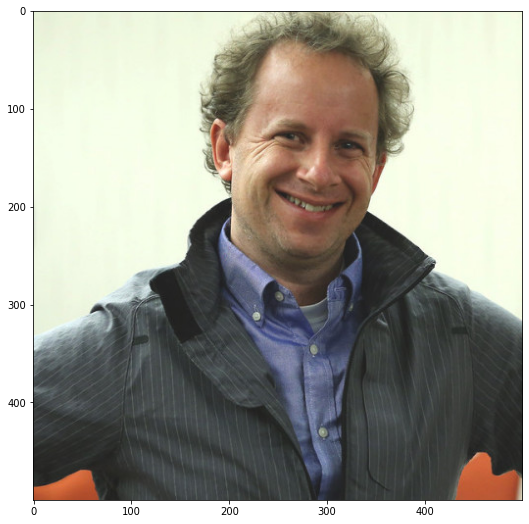

In [179]:
def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    normalized = gray/255.
    resized = cv2.resize(normalized, (224,224))
    return resized

image = cv2.imread('images/jeremy-howard.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

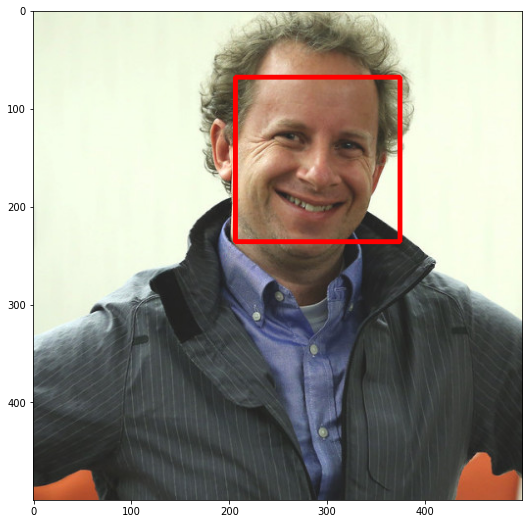

In [180]:
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(image, 1.2, 2)

image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [181]:
from models import Net

net = Net()
net.load_state_dict(torch.load('v2_model.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (bn6): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [182]:
image_copy = np.copy(image)

# haar cascade find very tight face region, it's better to add some padding
padding = 30

images = []
keypoints = []
rois_shapes = []

for (x,y,w,h) in faces:
    roi = image_copy[y-padding:y+h+padding, x-padding:x+w+padding]
    prep_roi = preprocess_roi(roi)    
    
    # add 1 dim as batch dim and 1 dim as color channel
    batch = torch.tensor(prep_roi, dtype=torch.float32).reshape([1,1,prep_roi.shape[0], prep_roi.shape[1]])
    
    preds = net(batch)
    preds = preds.data.reshape(-1, 2).numpy()*50.+100

    images.append(roi)
    keypoints.append(preds)
    rois_shapes.append(roi.shape)


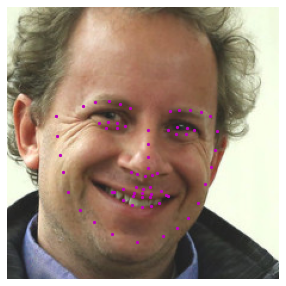

In [183]:
faces_count = len(images)

for i in range(faces_count):
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1, faces_count, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.scatter(keypoints[i][:, 0], keypoints[i][:, 1], s=20, marker='.', c='m')
    plt.axis("off")
plt.show()

In [184]:
faces_with_glasses = []
for i in range(faces_count):
    image_copy = np.copy(images[i])

    # top-left location for sunglasses to go
    # 17 = edge of left eyebrow
    x = int(keypoints[i][17, 0])
    y = int(keypoints[i][17, 1])

    # height and width of sunglasses
    # h = length of nose
    h = int(abs(keypoints[i][27,1] - keypoints[i][34,1]))
    # w = left to right eyebrow edges
    w = int(abs(keypoints[i][17,0] - keypoints[i][26,0]))

    # read in sunglasses
    sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
    # resize sunglasses
    new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

    # get region of interest on the face to change
    roi_color = image_copy[y:y+h,x:x+w]

    # find all non-transparent pts
    ind = np.argwhere(new_sunglasses[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
    for j in range(3):
        roi_color[ind[:,0],ind[:,1],j] = new_sunglasses[ind[:,0],ind[:,1],j]    
    # set the area of the image to the changed region with sunglasses
    image_copy[y:y+h,x:x+w] = roi_color

    # 33 = bottom of nose 
    x = int(abs(keypoints[i][33,1] - keypoints[i][51,1]))
    y = int(abs(keypoints[i][33,0] - keypoints[i][51,0]))

    # height and width of moustache
    # h = length of mouth
    h = int(abs(keypoints[i][51,1] - keypoints[i][57,1]))
    # w = width of mouth
    w = int(abs(keypoints[i][48,0] - keypoints[i][54,0]))

    h += int(h*.3)
    w += int(w*.3)

    # read in sunglasses
    moustache = cv2.imread('images/moustache.png', cv2.IMREAD_UNCHANGED)
    # resize sunglasses
    new_moustache =  cv2.resize(moustache, (w, h), interpolation = cv2.INTER_CUBIC)

    # get region of interest on the face to change
    roi_color = image_copy[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)]

    # find all non-transparent pts
    ind = np.argwhere(new_moustache[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
    for k in range(3):
        roi_color[ind[:,0],ind[:,1],k] = new_moustache[ind[:,0],ind[:,1],k]    
    # set the area of the image to the changed region with sunglasses
    image_copy[int(y-h/2):int(y+h/2),int(x-w/2):int(x+w/2)] = roi_color


    faces_with_glasses.append(image_copy)

IndexError: index 4 is out of bounds for axis 0 with size 0

In [185]:
for i in range(faces_count):
    face_with_glasses = faces_with_glasses[i]
    old_shape = rois_shapes[i]
    print(old_shape)
    resized_back = cv2.resize(face_with_glasses, (old_shape[0], old_shape[1]))
    x,y,w,h = faces[i]
    image[y-padding:y+h+padding, x-padding:x+w+padding] = resized_back

IndexError: list index out of range

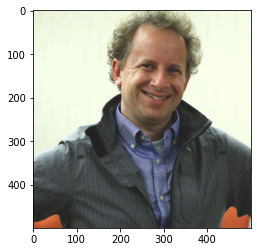

In [186]:
plt.imshow(image)